# Image Segmentation Project

Segmentation of Coloured Images into various Regions of Interest (ROI)

This Notebook is to be used with Google colab and Google Drive

### The Road Ahead

I break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.


* [Step 1](#step1): Change the runtime compute to GPU
* [Step 2](#step2): Install libraries (for google colab)
* [Step 3](#step3): Import required libraries
* [Step 4](#step4): Mount google Drive
* [Step 5](#step5): Create Segmentation class to do preprocessing and define CRF Model
* [Step 6](#step6): Load and Preprocess image and label data
* [Step 7](#step7): Define and Training Neural network model
* [Step 8](#step8): Segmentation by Conditinal Random Field (CRF) using CNN prediction as Unary energy
* [Step 9](#step9): Predict on Your new image
* [Observation](#step10): Some observation regarding model

<a id='step1'></a>
### STEP-1 Change the runtime compute to GPU

Yo can do this by following below path

Runtime-->change runtime type-->select GPU-->click save

<a id='step2'></a>
### **STEP-2**-Install libraries (for google colab)
Execute the below cell to do the installation

In [1]:
!pip install pydensecrf 
!pip install segmentation_models

     |████████████████████████████████| 1.0MB 11.8MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153661 sha256=98b6ca9556a3f9ebc9d67762f141817a0d953a89dd802ddb8fb1018f4818070f
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


<a id='step3'></a>
### STEP-3 - Import required libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
from skimage.color import gray2rgb
import glob


<a id='step4'></a>
### STEP-4 Mount google Drive

When promted for authorization code, click on the link generated and follow steps. Then paste code generated in the box and press ENTER. Make sure you have uploaded the project folder in Google Drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='step5'></a>
###STEP-5 Create Segmentation class

This class does the following


1.   Create individual class mask for training segmentation models
2.   Merge individual class mask predicted by Neural Net model into one image in mutually exclusive process
3.   Carry out Neural net prediction for any image
4.   Carry out conditional random field modelling and inferencing for segmentation taking Urinary energy from Neural net predictions
5.   Few misc. things like extract color and number of classes



In [0]:
class Segmentation():
  def __init__(self,colors=None,labels=None):
    self.colors = colors
    self.n_labels = labels
  
  def mask_label(self,img,output_shape):
    if isinstance(self.colors,type(None)):
      self.colors = self.get_class_color(img)

    label_mask = np.full((output_shape[1],output_shape[0],4),0)
    for i,color in enumerate(self.colors):
      temp_mask = cv2.resize((img==color).astype(np.uint8)[...,0]*255,(output_shape[0],output_shape[1]))
      
      #resizing changes the pixel value so need to binarize picture again
      _,temp_mask = cv2.threshold(temp_mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      label_mask[:,:,i] = temp_mask

    return label_mask

  def get_unique_color_labels(self,label_image):
    annotated_image = label_image.astype(np.uint32)

    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0].astype(np.uint32) + (annotated_image[:,:,1]<<8).astype(np.uint32) + (annotated_image[:,:,2]<<16).astype(np.uint32)
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)
     
    return colors, labels

  def get_class_color(self,label_image):
    colors, labels = self.get_unique_color_labels(label_image)
    self.n_labels = len(set(labels.flat))
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    return colorize

  def predict(self,images,model):
    prediction = model.predict(images[np.newaxis,]) if len(images.shape)==3 else model.predict(images)
    return prediction

  def merge_mask(self,images):
    merged_masks = self.colors[((images*[1,2,3,4]).sum(axis=-1)).astype(int) -1]
    return merged_masks

  def merge_mask_exclusively(self,prediction):
    #assign pixel a class with maximum probabilty 
    prediction[np.where(prediction==np.amax(prediction,axis=-1,keepdims=True))]=1
    prediction[np.where(prediction!=np.amax(prediction,axis=-1,keepdims=True))]=0
    #merge individual class mask into one with different colors
    merged_masks = self.merge_mask(prediction)
    return merged_masks

  def crf(self,original_images, annotated_images):
      result=[]
      # Converting annotated image to RGB if it is Gray scale
      if len(annotated_images.shape)!=4:
        annotated_images = [annotated_images]
        original_images = [original_images]

      for i,annotated_image in enumerate(annotated_images):
        if(len(annotated_image.shape)<3):
            annotated_image = gray2rgb(annotated_image).astype(np.uint32)
        _, labels = self.get_unique_color_labels(annotated_image)
        
        #Setting up the CRF model
        d = dcrf.DenseCRF2D(original_images[i].shape[1], original_images[i].shape[0], self.n_labels)
        U = unary_from_labels(labels, self.n_labels, gt_prob=0.90, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(4, 4), srgb=(50, 50, 50), rgbim=original_images[i],
                          compat=10,
                          kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)
            
        #Run Inference for 5 steps 
        Q = d.inference(5)

        # Find out the most probable class for each pixel.
        MAP = np.argmax(Q, axis=0)

        # Convert the MAP (labels) back to the corresponding colors and save the image.
        MAP = self.colors[MAP,:]
        result.append(MAP.reshape(original_images[i].shape))
      return np.array(result)


<a id='step6'></a>
### Step-6 Load and Preprocess image and label data

In [0]:
segment = Segmentation()

In [0]:
#set training image size and folder path
train_image_size = (448,224)
training_image_folder = "/content/drive/My Drive/segmentation/dataset/"
validation_image_folder = "/content/drive/My Drive/segmentation/dataset/"

In [0]:
#load images and labels
image_list_train=[cv2.imread(name) for name in sorted(glob.glob(training_image_folder+'*.jpg'))]
image_list_label=[cv2.imread(name) for name in sorted(glob.glob(validation_image_folder+"*.png"))]

# resize images and extract individual class label from merged label image
image_list_train_resize = [cv2.resize(img,train_image_size) for img in image_list_train]
image_list_label_perclass = [segment.mask_label(img,train_image_size) for img in image_list_label]


In [21]:
sorted(glob.glob(validation_image_folder+"*.png"))

['/content/drive/My Drive/segmentation/dataset/1_label.png',
 '/content/drive/My Drive/segmentation/dataset/2_label.png',
 '/content/drive/My Drive/segmentation/dataset/3_label.png',
 '/content/drive/My Drive/segmentation/dataset/4_label.png',
 '/content/drive/My Drive/segmentation/dataset/5_label.png',
 '/content/drive/My Drive/segmentation/dataset/6_label.png']

###Visualize Original Image and Labeled data

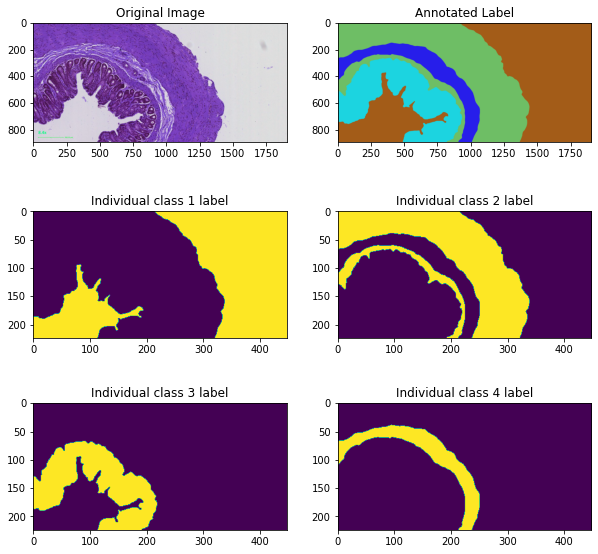

In [7]:
fig, axs = plt.subplots(3, 2,figsize=(10,10))
axs[0, 0].imshow(image_list_train[0])
axs[0, 0].set_title('Original Image')
axs[0, 1].imshow(image_list_label[0])
axs[0, 1].set_title('Annotated Label')
axs[1, 0].imshow(image_list_label_perclass[0][...,0])
axs[1, 0].set_title('Individual class 1 label')
axs[1, 1].imshow(image_list_label_perclass[0][...,1])
axs[1, 1].set_title('Individual class 2 label')
axs[2, 0].imshow(image_list_label_perclass[0][...,2])
axs[2, 0].set_title('Individual class 3 label')
axs[2, 1].imshow(image_list_label_perclass[0][...,3])
axs[2, 1].set_title('Individual class 4 label')
plt.show()


<a id='step7'></a>
###STEP - 7 Training Neural network model

In [8]:
#setting Up
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, DiceLoss,CategoricalFocalLoss
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import keras
from keras.callbacks.callbacks import ModelCheckpoint

#define and compile model
def get_compiled_model(BACKBONE='efficientnetb3',LR=0.0001):

  model = Unet(BACKBONE,classes=4, activation='softmax')
  preprocess_input = get_preprocessing(BACKBONE)
  optim = keras.optimizers.Adam(LR)
  dice_loss = DiceLoss(class_weights=np.array([.5, 1,1, 1])) 
  focal_loss = CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  model.compile(optim, loss=total_loss, metrics=[iou_score])

  return model,preprocess_input

#set training parameters
batch_size=5
epochs=500
LR = .0001
BACKBONE='efficientnetb3'
model_filepath = 'model_best.hdf5'

checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#get model
model,preprocess_input = get_compiled_model(BACKBONE,LR)

#train set no. = 5
x_train = np.array(image_list_train_resize[:5])
y_train = np.array(image_list_label_perclass[0:5])

#test set no. = 1
x_val = np.array(image_list_train_resize[-1])[np.newaxis,]
y_val = np.array(image_list_label_perclass[-1])[np.newaxis,]

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)



Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [9]:
TRAIN_MODEL = False

# fit model
if TRAIN_MODEL :
  model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_val, y_val),
      callbacks = [checkpoint]
  )
  model.load_weights(model_filepath)
else:
  print("Skiping model training and using pretrained weights. To train new model set TRAIN_MODEL = True")
  trained_model_path = '/content/drive/My Drive/segmentation/pretrained_model/model.h5'
  model.load_weights(trained_model_path)


Skiping model training and using pretrained weights. To train new model set TRAIN_MODEL = True


### Lets do a prediction by trianed model on validation image with Hard threshold of 0.5

Selct which model you want to use for prediction

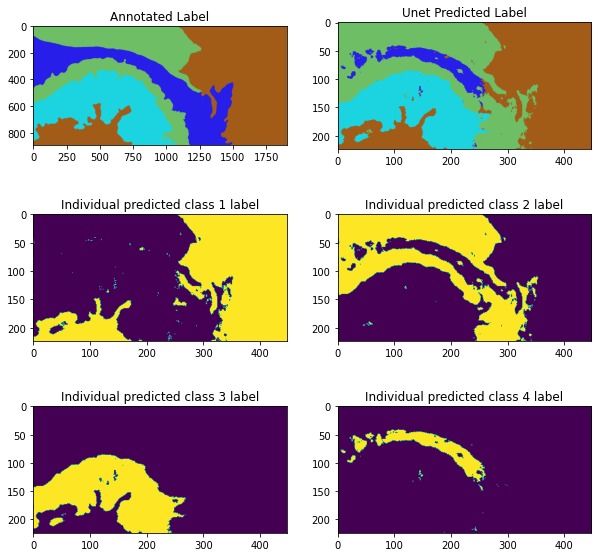

In [10]:
##########Don't change anything below thing##########

prediction = segment.predict(x_val,model)
merged_predicted_label=segment.merge_mask_exclusively(prediction)

fig, axs = plt.subplots(3, 2,figsize=(10,10))
axs[0, 0].imshow(image_list_label[-1])
axs[0, 0].set_title('Annotated Label')
axs[0, 1].imshow(merged_predicted_label[0])
axs[0, 1].set_title('Unet Predicted Label')
axs[1, 0].imshow(prediction[0][...,0]>.5)
axs[1, 0].set_title('Individual predicted class 1 label')
axs[1, 1].imshow(prediction[0][...,1]>.5)
axs[1, 1].set_title('Individual predicted class 2 label')
axs[2, 0].imshow(prediction[0][...,2]>.5)
axs[2, 0].set_title('Individual predicted class 3 label')
axs[2, 1].imshow(prediction[0][...,3]>.5)
axs[2, 1].set_title('Individual predicted class 4 label')
plt.show()


<a id='step8'></a>
###STEP-8 Segmentation by Conditinal Random Field (CRF) using CNN prediction as Unary energy

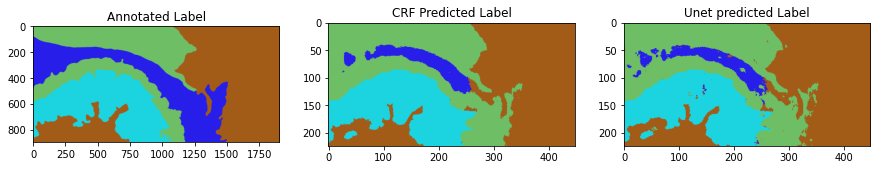

In [11]:
Validation_image = image_list_train_resize[-1]
crf_predict_label = segment.crf(Validation_image,merged_predicted_label[0])

fig, axs = plt.subplots(1, 3,figsize=(15,15))
axs[0].imshow(image_list_label[-1])
axs[0].set_title('Annotated Label')
axs[1].imshow(crf_predict_label[0])
axs[1].set_title('CRF Predicted Label')
axs[2].imshow(merged_predicted_label[0])
axs[2].set_title('Unet predicted Label')
plt.show()


<a id='step9'></a>
### STEP-9 Predict on your image

1.   Provide Google drive path for your jpg images 
2.   New images will be predicted for 4 classes (3 + 1 background)
3.   Make sure you don't add your images in dataset folder. Next time training will be affected. Add in myimages folder
4.   Output label is saved in output folder (takes few seconds to appear in drive)



/content/drive/My Drive/segmentation/myimages/6.jpg


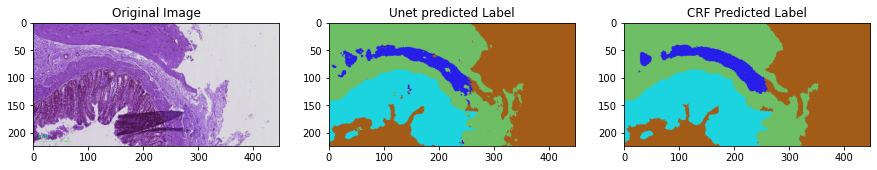

In [12]:
#Enter your image name eg. 'myimage.jpg'
image_name = ''

#enter model path 
# leave as it is if you want to use pretrained model. 
# Use 'model_best.hdf5' if you want to use recently trained model.
model_path = '' 

#----------------------Don't change anything below this-----------
my_image_folder_path = '/content/drive/My Drive/segmentation/myimages/'
output_folder = '/content/drive/My Drive/segmentation/output/'
trained_model_path = '/content/drive/My Drive/segmentation/pretrained_model/model.h5'
use_model_path = model_path if model_path else trained_model_path
img_name = my_image_folder_path+image_name if image_name else '/content/drive/My Drive/segmentation/myimages/6.jpg'
colors = np.array([[163,  92,  24],
       [110, 190, 101],
       [ 28, 212, 224],
       [ 39,  30, 234]],dtype=np.uint8)
segment = Segmentation(colors,4)
train_image_size = (448,224)
try:
  image = cv2.imread(img_name)
  myimage = cv2.resize(image,train_image_size)[np.newaxis,]
except:
  print(image_name, " not found")

try:
   pretrained_model
except :
  pretrained_model,preprocess_input = get_compiled_model()
pretrained_model.load_weights(use_model_path)
processed_image = preprocess_input(myimage)
myimage_predict = segment.predict(processed_image,pretrained_model)
merged_pred_label=segment.merge_mask_exclusively(myimage_predict)
crf_pred_label = segment.crf(myimage,merged_pred_label)
cv2.imwrite(output_folder+image_name.split('.')[0]+'_output_label_CRF.jpg',cv2.resize(crf_pred_label[0],(image.shape[1],image.shape[0])))
cv2.imwrite(output_folder+image_name.split('.')[0]+'_output_label_Unet.jpg',cv2.resize(merged_pred_label[0],(image.shape[1],image.shape[0])))

print(img_name)
fig, axs = plt.subplots(1, 3,figsize=(15,15))
axs[0].imshow(myimage[0])
axs[0].set_title('Original Image')
axs[1].imshow(merged_pred_label[0])
axs[1].set_title('Unet predicted Label')
axs[2].imshow(crf_pred_label[0])
axs[2].set_title('CRF Predicted Label')
plt.show()

<a id='step10'></a>
### Observations

*   Predictions are based on hard threshold of 0.5 and final predicted labels are non overlaping. One can use different hard threshold and overlapping predicted labels on the basis of use case.
*   CRF model has two hyperparameter related to proximity and smoothness. This can be tuned for further enhancement. 
*   CNN trained model is over fit model as data is way too less. Above modelling only represents a structure. Good model will be trained with more data.
*   Image Augmentation should be used (I didn't have time so could not add that)




